In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn as nn
import torch
from torch import nn
from itertools import product
from monk_helpers import CV,SEED
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import time




Create reproducible results

In [513]:
torch.manual_seed(SEED)
np.random.seed(SEED)
gen = torch.Generator().manual_seed(SEED)
SEEDS = list(range(40,46))


In [514]:
# Datasets Path
TR_PATH_1 = "./monks/datasets/monks-1.train"
TS_PATH_1 = "./monks/datasets/monks-1.test"
# Datasets Path
TR_PATH_2 = "./monks/datasets/monks-2.train"
TS_PATH_2 = "./monks/datasets/monks-2.test"
# Datasets Path
TR_PATH_3 = "./monks/datasets/monks-3.train"
TS_PATH_3 = "./monks/datasets/monks-3.test"

In [515]:

def plot_graph(train_losses,losses,epochs,title):
    num_epochs = list(range(0, epochs))  
    # Plotting
    plt.plot(num_epochs, train_losses, label=' Training',linestyle='-')
    plt.plot(num_epochs, losses, label=title+' MSE',linestyle='--')

    plt.title('Training and '+title+' Losses Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

In [516]:

def plot_graph_accuracy(train_accuracies, accuracies, epochs):
    num_epochs = list(range(0, epochs))
    
    # Plotting
    print("TRAIN ACCURACY:", train_accuracies[-1])
    plt.plot(num_epochs, train_accuracies, label='Training Accuracy',linestyle='-')
    plt.plot(num_epochs, accuracies, label='Test Accuracy',linestyle='--')

    plt.title('Training and Test Accuracies Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [517]:
class Net(nn.Module):

  def __init__(self, input_size, units, output_size):
    super().__init__()
    self.units = units

    self.l1 = nn.Linear(input_size, units)
    self.l2 = nn.Linear(units, output_size)

  def forward(self, x):
    out = torch.tanh(self.l1(x))
    out = torch.sigmoid(self.l2(out))
    return out


def reset_weights(net):
  for param in net.parameters():
    torch.nn.init.uniform_(param, a=-0.7, b=0.7)

In [518]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  names = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
  data = pd.read_csv(path, dtype=object, delim_whitespace=True, header=None, skipinitialspace=True, names=names)

  X = data.drop(['class','id'], axis=1)
  X = pd.get_dummies(X).astype(float).to_numpy()
  y = data.drop(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id'], axis=1)
  y = y.astype(float).to_numpy()


  return np.concatenate((y, X), axis=1)

In [519]:
class EarlyStopper:
  def __init__(self, epochs_to_wait=1, min_delta=0):
    self.min_training_loss = np.inf
    self.epochs_to_wait = epochs_to_wait
    self.min_delta = min_delta
    self.counter = 0

  def check_early_stop(self, training_loss):
    if training_loss > (self.min_training_loss - self.min_delta):
      self.counter +=1
      if self.counter >= self.epochs_to_wait:
        return True
    else: 
      self.counter = 0
    if training_loss < self.min_training_loss:
      self.min_training_loss = training_loss
    
    return False

In [520]:
def Padding(validation_losses_fold,train_losses_fold):
    max_epochs = max(map(len, validation_losses_fold))

    for validation_loss_arr in validation_losses_fold:
        while len(validation_loss_arr) < max_epochs:
            validation_loss_arr.append(validation_loss_arr[-1])

    for train_loss_arr in train_losses_fold:
      while len(train_loss_arr) < max_epochs:
            train_loss_arr.append(train_loss_arr[-1])

    print(len(validation_losses_fold))
    return validation_losses_fold,train_losses_fold

In [521]:
def Mean(validation_avg_loss_fold,train_losses_fold,n_folds):
    max_epochs = max(map(len, validation_avg_loss_fold))
    validation_avg_loss = []
    train_avg_loss = []
    
    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(validation_avg_loss_fold)):
            temp_loss += validation_avg_loss_fold[j][i]
        validation_avg_loss.append(temp_loss/n_folds)

    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(train_losses_fold)):
            temp_loss += train_losses_fold[j][i]
        train_avg_loss.append(temp_loss/n_folds)
    
    return validation_avg_loss,train_avg_loss
    

    

In [522]:
def fit_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,testloader):
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization

    optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    

    
    train_losses = []
    test_losses = []


    
    epoch_train_accuracies = []
    epoch_test_accuracies = []

    early_stopper = EarlyStopper(epochs_to_wait=40, min_delta=1e-5)

    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      print(f'Starting epoch {epoch+1}')

      # Set current loss and accuracy value for train
      train_loss = 0.0
      epoch_train_accuracy = 0.0

      # Set current loss and accuracy value for test
      test_loss = 0.0
      epoch_test_accuracy = 0.0


      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Zero the gradients
        optimizer.zero_grad() 

        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)

        # Update accuracy
        for output, target in zip(outputs, targets):
          output = 0 if output.item() < 0.5 else 1
          if output == target.item():
            epoch_train_accuracy += 1

      # Print loss values
      epoch_train_loss = train_loss / len(trainloader.sampler)
      train_losses.append(epoch_train_loss)

      epoch_train_accuracy /= len(trainloader.sampler)

      epoch_train_accuracies.append(epoch_train_accuracy)

      
      with torch.no_grad():
        # Iterate over the testing data and generate predictions
        for i, data in enumerate(testloader, 0):

          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
        
          outputs = network(inputs)

          loss = loss_function(outputs, targets)
          
          test_loss += loss.item() * inputs.size(0)
          # Update accuracy
          for output, target in zip(outputs, targets):
            output = 0 if output.item() < 0.5 else 1
            if output == target.item():
              epoch_test_accuracy += 1

        epoch_test_loss = test_loss / len(testloader.sampler)    
        test_losses.append(epoch_test_loss)


        
        epoch_test_accuracy /= len(testloader.sampler)

        epoch_test_accuracies.append(epoch_test_accuracy)
        
        print(epoch_test_loss)
        if early_stopper.check_early_stop(epoch_test_loss):
          print("Early stopping: ",epoch)
          break

    plot_graph(train_losses,test_losses,epoch+1,"test")
    plot_graph_accuracy(epoch_train_accuracies,epoch_test_accuracies,epoch+1)

    return network,train_losses[-1],test_losses[-1]


In [523]:
def k_fold_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,validationloader):
    
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


    early_stopper = EarlyStopper(epochs_to_wait=40, min_delta=1e-5)
    train_losses = []
    validaition_losses = []

    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Set current loss value
      train_loss = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Zero the gradients
        optimizer.zero_grad() 
        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)

      avg_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(avg_train_loss) 

      # Evaluationfor this fold
      valid_loss = 0.0 
      with torch.no_grad():
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

          # Get inputs
          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
          
          # Generate outputs
          outputs = network(inputs)

          loss = loss_function(outputs, targets)

          # Calculate loss
          valid_loss += loss.item() * inputs.size(0)

      
        avg_valid_loss = valid_loss / len(validationloader.sampler) #used to find the best parameters of the model
        validaition_losses.append(avg_valid_loss)


        # Early stopping
        if early_stopper.check_early_stop(avg_valid_loss):
          print("Early stopping:", epoch)
          break
      
    return avg_valid_loss,avg_train_loss,validaition_losses,train_losses


In [524]:
def execute_folds(kfold,dataset,batch_size,input_size, hidden_size, output_size, learning_rate, epochs,
    loss_function, momentum, opt, weight_decay):

    validation_avg_loss_fold = 0
    train_avg_loss_fold = 0
    validation_losses_fold = []
    train_losses_fold = []
    num_iterations = 0
    current_config = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'momentum': momentum,
        'opt': opt,
        'weight_decay': weight_decay,
        "batch_size":batch_size,
        "loss_function":loss_function
    }
 
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 

        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss,train_loss,validation_losses,train_losses = k_fold_model(learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader)   
        validation_avg_loss_fold  += validation_loss
        train_avg_loss_fold += train_loss
        validation_losses_fold.append(validation_losses)
        train_losses_fold.append(train_losses)

        num_iterations += 1


    #validation and train average over all folds
    validation_avg_loss_fold /= num_iterations
    train_avg_loss_fold /= num_iterations
    
    validation_losses_fold,train_losses_fold = Padding(validation_losses_fold,train_losses_fold)

    validation_losses_mean, train_losses_mean = Mean(validation_losses_fold, train_losses_fold,n_folds=num_iterations)
    
    plot_graph(train_losses_mean,validation_losses_mean,len(validation_losses),"validation") 
    


    return (validation_avg_loss_fold,train_avg_loss_fold,current_config)

function that executes the folds for each combination of parameters

In [525]:
def dogridsearch(dataset_train_part,params_grid,output_size,input_size,seeds):
    
    dataset = dataset_train_part
    # Set fixed random number seed
    loss_function = nn.MSELoss()

    # Define the K-fold Cross Validator
    kfold = CV 
    
    # K-fold Cross Validation model evaluation
    best_params = None

    actual_it = 0
    total_iterations = len(params_grid["epochs"]) * len(params_grid["optimizer"]) * len(params_grid["hidden_size"]) * len(params_grid["learning_rate"]) * len(params_grid["batch_size"]) * len(params_grid["weight_decay"]) * len(params_grid["momentum"]) 


    configurations = []

    for epochs, opt, hidden_size, learning_rate, batch_size, weight_decay, momentum in product(params_grid["epochs"],params_grid["optimizer"], params_grid["hidden_size"], params_grid["learning_rate"], params_grid["batch_size"], params_grid["weight_decay"], params_grid["momentum"]):
        #print the actual percentage of the grid search
        print(f'Actual iter {(actual_it/total_iterations)*100}%')
        for seed in seeds:
            print("Working with seed:",seed)
            torch.manual_seed(seed)
            (validation_avg_loss_fold,train_avg_loss_fold,current_config) = execute_folds(kfold=kfold,dataset=dataset,learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                            ,opt=opt,output_size=output_size,weight_decay=weight_decay,batch_size=batch_size)
            configurations.append((validation_avg_loss_fold, train_avg_loss_fold,current_config))
        
        actual_it += 1

    val_mse = []
    train_mse = []
    #best 
    for conf_val in configurations:
        val_mse.append(conf_val[0])
        train_mse.append(conf_val[1])
        if best_params is None or conf_val[0] < best_params[0]:
                current_config = conf_val[2]
                best_params = (conf_val[0],conf_val[1]
                ,current_config['learning_rate'], current_config['epochs'],current_config["loss_function"],current_config['hidden_size'],current_config['momentum'],current_config['opt'],
                current_config['weight_decay'],
                current_config['batch_size'])

    print("TRAIN MEAN MSE",np.mean(train_mse))
    print("TRAIN STD",np.std(train_mse))
    print("VALIDATION MEAN MSE",np.mean(val_mse))
    print("VALIDATION STD",np.std(val_mse))

    return best_params

test the created model and plot training/test error

In [526]:
def train_test_model(dataset_train_part,dataset_test_part,best_params,seeds):

    train_subsampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_train_part)), gen)

    trainloader = torch.utils.data.DataLoader(
                        dataset_train_part, 
                        batch_size=best_params[9], sampler=train_subsampler)

    test_subsampler =  torch.utils.data.SubsetRandomSampler(range(len(dataset_test_part)), gen)
    testloader = torch.utils.data.DataLoader(
                        dataset_test_part, 
                        batch_size=best_params[9], sampler=test_subsampler)
    train_error_seed = []
    test_error_seed = []
    for seed in seeds:
        # Start the timer
        start = time.time()
        print("Working with seed:",seed)
        torch.manual_seed(seed)
        best_net,train_error,test_error = fit_model(learning_rate=best_params[2],epochs=best_params[3],hidden_size=best_params[5],input_size=17,loss_function=best_params[4],
                        momentum=best_params[6],opt=best_params[7],output_size=1,trainloader=trainloader,weight_decay=best_params[8],testloader=testloader) 
        train_error_seed.append(train_error)
        test_error_seed.append(test_error)
        end = time.time()
        print("Refit Time: {:.2f} seconds".format(end - start))


    print("TRAIN MEAN MSE",np.mean(train_error_seed))
    print("TRAIN STD",np.std(train_error_seed))
    print("TEST MEAN MSE",np.mean(test_error_seed))
    print("TEST STD",np.std(test_error_seed))

    return best_net

Actual iter 0.0%
Working with seed: 40
Early stopping: 148
Early stopping: 128
Early stopping: 346
5


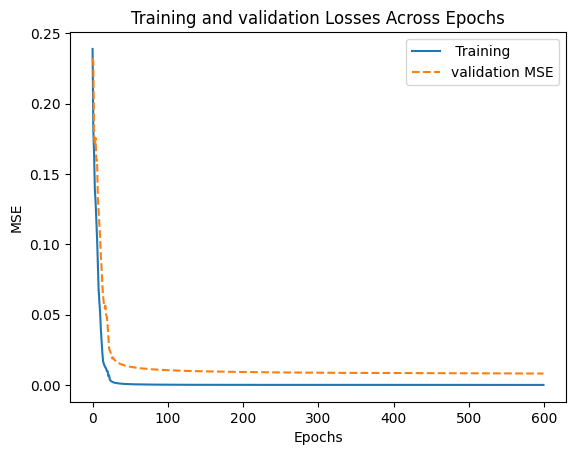

Working with seed: 41
Early stopping: 167
Early stopping: 56
Early stopping: 113
Early stopping: 169
Early stopping: 104
5


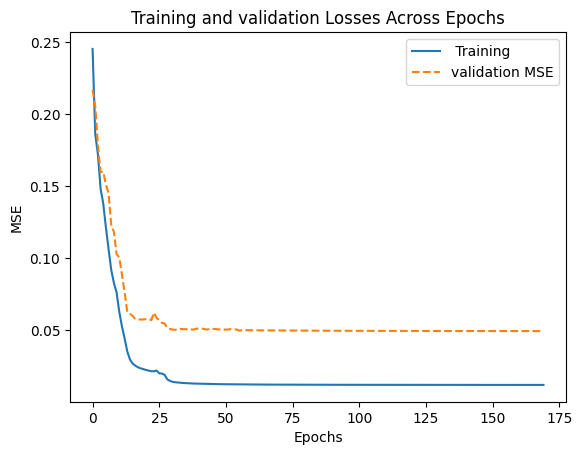

Working with seed: 42
Early stopping: 386
Early stopping: 301
Early stopping: 62
Early stopping: 124
Early stopping: 443
5


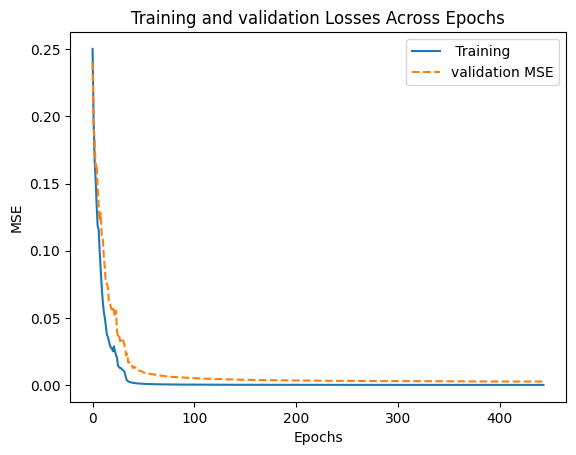

Working with seed: 43
Early stopping: 223
Early stopping: 57
Early stopping: 208
Early stopping: 182
5


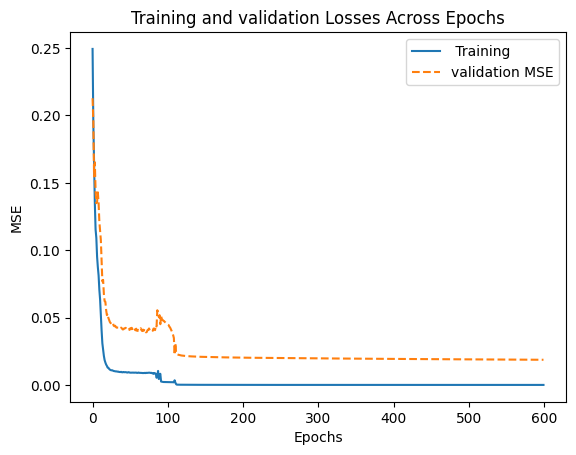

Working with seed: 44
Early stopping: 135
Early stopping: 56
Early stopping: 500
Early stopping: 376
5


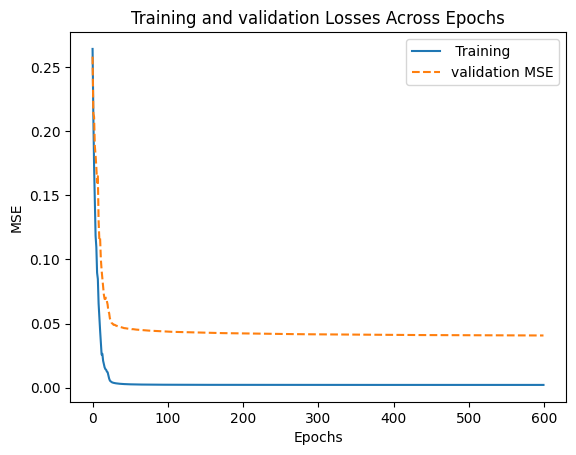

Working with seed: 45
Early stopping: 63
Early stopping: 132
Early stopping: 231
Early stopping: 109
Early stopping: 268
5


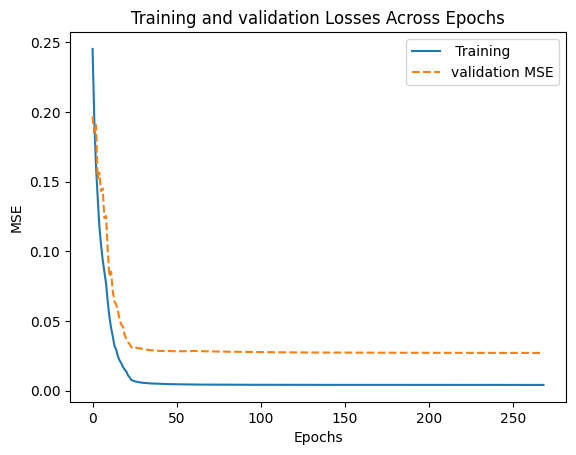

TRAIN MEAN MSE 0.0031266400265079416
TRAIN STD 0.004280706013627153
VALIDATION MEAN MSE 0.02447320060132167
VALIDATION STD 0.01667060529297906


In [527]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],


}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],

}
    

dataset_train_part = read_ds(TR_PATH_1)
dataset_test_part = read_ds(TS_PATH_1)

dataset = dataset_train_part



best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size,seeds = SEEDS)
        




monk 1:
Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.0022038360655424185, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)

In [528]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.0026729325915172616, 0.000154242019753461, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Working with seed: 40
Starting epoch 1
0.19529052992799767
Starting epoch 2
0.195893795143261
Starting epoch 3
0.2127373261998097
Starting epoch 4
0.1813035681757524
Starting epoch 5
0.1669847194355464
Starting epoch 6
0.17857997703443593
Starting epoch 7
0.13591111540207984
Starting epoch 8
0.10243602189088792
Starting epoch 9
0.08836356765500063
Starting epoch 10
0.08594300570742537
Starting epoch 11
0.08012280999887648
Starting epoch 12
0.07980858454485079
Starting epoch 13
0.07862872801100214
Starting epoch 14
0.07819066419378268
Starting epoch 15
0.07610025479408689
Starting epoch 16
0.0770338927433369
Starting epoch 17
0.07593658899754195
Starting epoch 18
0.07494117751095339
Starting epoch 19
0.07587571300380794
Starting epoch 20
0.072711450787446
Starting epoch 21
0.07216267643417706
Starting epoch 22
0.07177888932346832
Starting epoch 23
0.07297037625122121
Starting epoch 24
0.0733309277386272
Starting epoch 25
0.07354221923041795
Starting epoch 26
0.07103478297293325
Starting

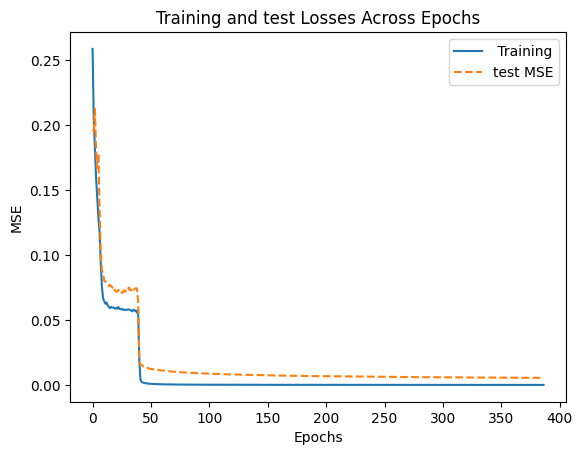

387
TRAIN ACCURACY: 1.0


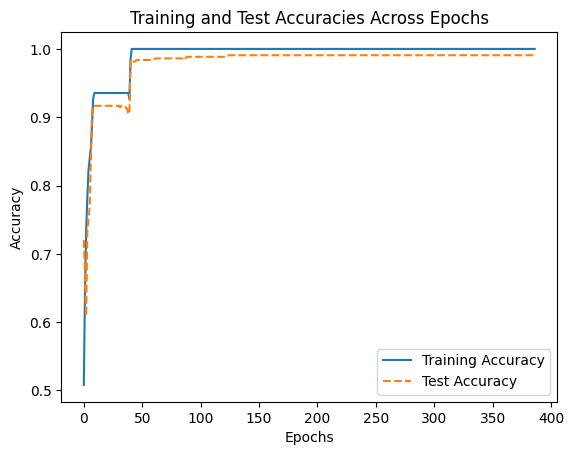

Refit Time: 28.76 seconds
Working with seed: 41
Starting epoch 1
0.20557675924566057
Starting epoch 2
0.18512587970191682
Starting epoch 3
0.17320225936257178
Starting epoch 4
0.13199501006898504
Starting epoch 5
0.14238639421226387
Starting epoch 6
0.12986381756383236
Starting epoch 7
0.1010123828029329
Starting epoch 8
0.0912675173797955
Starting epoch 9
0.08125646008476098
Starting epoch 10
0.07453171433169498
Starting epoch 11
0.06658295014521745
Starting epoch 12
0.07001756215079998
Starting epoch 13
0.047567136309226044
Starting epoch 14
0.03386866072078529
Starting epoch 15


KeyboardInterrupt: 

In [529]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params,seeds=SEEDS)  



accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



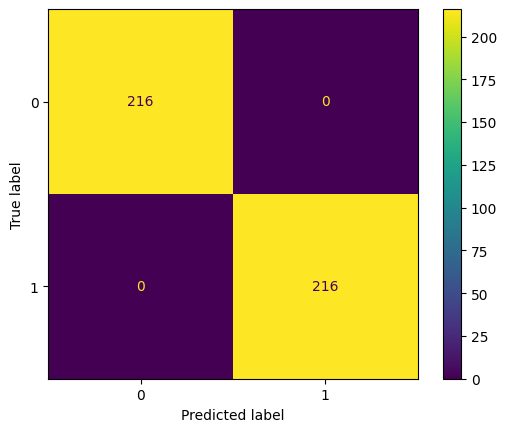

------------------------------------------------------------------------------------------------------


In [213]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 2

Actual iter 0.0%
Working with seed: 42
Early stopping: 100
Early stopping: 292
Early stopping: 273
Early stopping: 103
Early stopping: 112
5


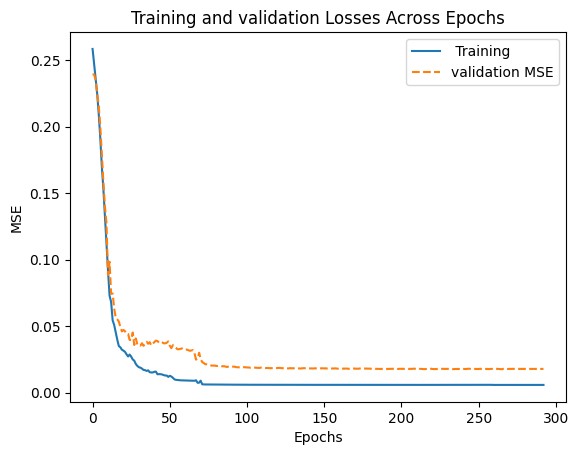

TRAIN MEAN MSE 0.005750128497527916
TRAIN STD 0.0
VALIDATION MEAN MSE 0.01778193564446828
VALIDATION STD 0.0


In [214]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],

}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],


}
    

dataset_train_part = read_ds(TR_PATH_2)
dataset_test_part = read_ds(TS_PATH_2)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size,seeds = [SEED])
        




In [215]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.01778193564446828, 0.005750128497527916, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Working with seed: 40
Starting epoch 1
0.2194551479899221
Starting epoch 2
0.22335917274985048
Starting epoch 3
0.2201478068061449
Starting epoch 4
0.20831346919725616
Starting epoch 5
0.19151026359328102
Starting epoch 6
0.15780044248310365
Starting epoch 7
0.13123958336008298
Starting epoch 8
0.0975285060294145
Starting epoch 9
0.052015594198127034
Starting epoch 10
0.03215009185347568
Starting epoch 11
0.022534834203758725
Starting epoch 12
0.009347137761155696
Starting epoch 13
0.006919399288664054
Starting epoch 14
0.004914306923941088
Starting epoch 15
0.003953541520146515
Starting epoch 16
0.003189028082286111
Starting epoch 17
0.002881810942738041
Starting epoch 18
0.002477281128112399
Starting epoch 19
0.002129183648826761
Starting epoch 20
0.0020192875693923
Starting epoch 21
0.0017249693447849023
Starting epoch 22
0.0016184776821453987
Starting epoch 23
0.001496191659868971
Starting epoch 24
0.0013139755225253153
Starting epoch 25
0.0012309263000605387
Starting epoch 26
0.00

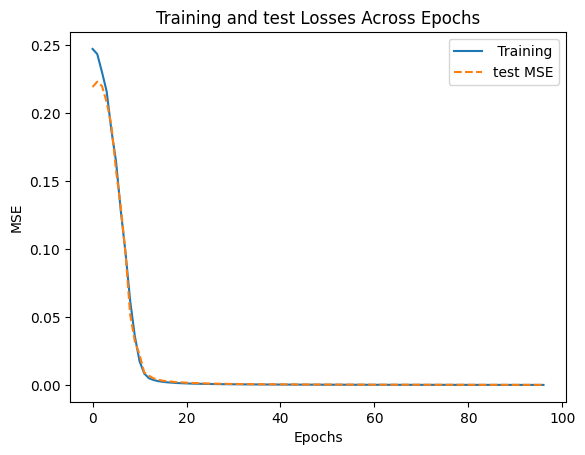

97


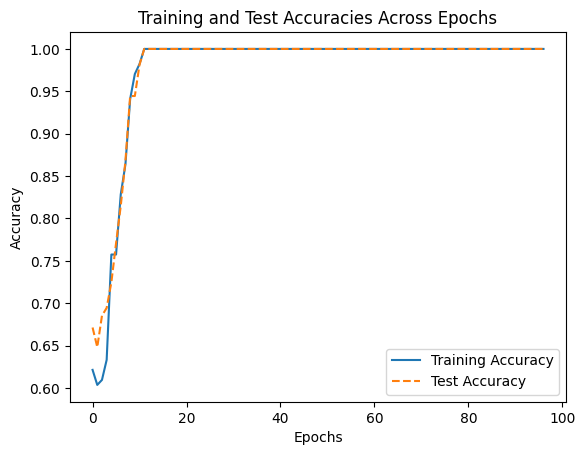

Refit Time: 1.97 seconds
Working with seed: 41
Starting epoch 1
0.258071517985728
Starting epoch 2
0.29338310313997445
Starting epoch 3
0.23565733280998688
Starting epoch 4
0.24093809816986322
Starting epoch 5
0.22173931504841204
Starting epoch 6
0.21385865016943878
Starting epoch 7
0.17375805317769172
Starting epoch 8
0.1412253647706368
Starting epoch 9
0.14214857762164212
Starting epoch 10
0.09868086231937115
Starting epoch 11
0.05353174157466532
Starting epoch 12
0.03558351024252328
Starting epoch 13
0.02918719464502862
Starting epoch 14
0.02241853421852553
Starting epoch 15
0.01994192115078611
Starting epoch 16
0.02221345354377667
Starting epoch 17
0.017719195271773194
Starting epoch 18
0.01686746423985352
Starting epoch 19
0.01762281367087713
Starting epoch 20
0.018754708170254836
Starting epoch 21
0.016920277620253426
Starting epoch 22
0.017134162932793347
Starting epoch 23
0.015372999867799485
Starting epoch 24
0.019207578148308566
Starting epoch 25
0.013799792829862175
Starting

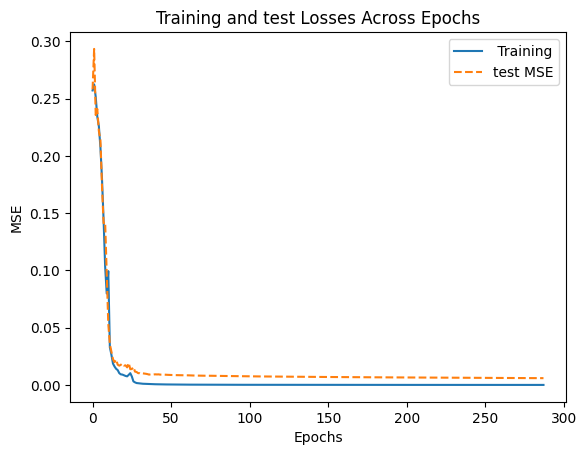

288


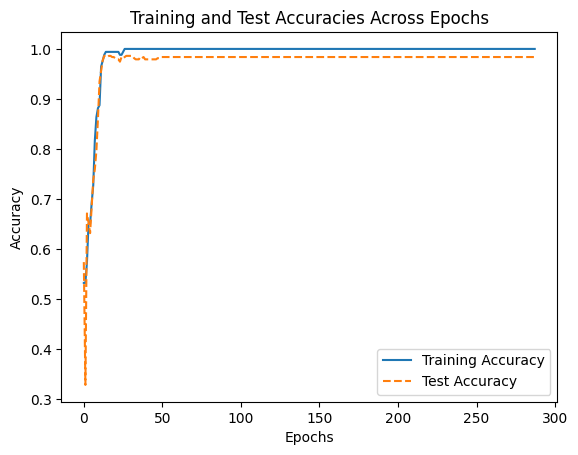

Refit Time: 5.46 seconds
Working with seed: 42
Starting epoch 1
0.23989243322500475
Starting epoch 2
0.22939423471689224
Starting epoch 3
0.2214469551626179
Starting epoch 4
0.24345183827810818
Starting epoch 5
0.20925938662279536
Starting epoch 6
0.1541202491433877
Starting epoch 7
0.09901664015423092
Starting epoch 8
0.06916110120342907
Starting epoch 9
0.01869752550178587
Starting epoch 10
0.007937717163090215
Starting epoch 11
0.0056646949443448745
Starting epoch 12
0.004671854428899543
Starting epoch 13
0.00354685016888349
Starting epoch 14
0.0028650255321904464
Starting epoch 15
0.002443709853213039
Starting epoch 16
0.00209764516572856
Starting epoch 17
0.0019110493771289907
Starting epoch 18
0.0016187311228821745
Starting epoch 19
0.0014986213531368844
Starting epoch 20
0.0013614326254119751
Starting epoch 21
0.0012593348696504512
Starting epoch 22
0.0011334466622361947
Starting epoch 23
0.0010775791997730266
Starting epoch 24
0.0009929862773990156
Starting epoch 25
0.000914199

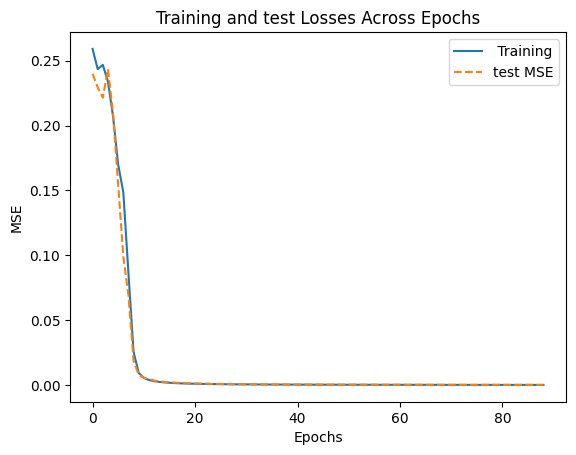

89


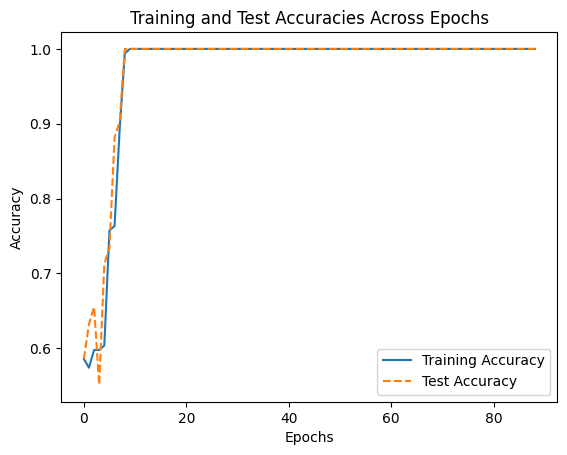

Refit Time: 1.58 seconds
Working with seed: 43
Starting epoch 1
0.22143832932191868
Starting epoch 2
0.22162685515703978
Starting epoch 3
0.22520192602166422
Starting epoch 4
0.22108510040022708
Starting epoch 5
0.23631240627555936
Starting epoch 6
0.22568885312864073
Starting epoch 7
0.220928688844045
Starting epoch 8
0.2370141715121766
Starting epoch 9
0.22500713314447138
Starting epoch 10
0.2313204714079836
Starting epoch 11
0.20622834308003937
Starting epoch 12
0.29776534658891185
Starting epoch 13
0.1863318434054101
Starting epoch 14
0.18110665722094751
Starting epoch 15
0.1730152142484224
Starting epoch 16
0.18761275331834676
Starting epoch 17
0.1662859471635548
Starting epoch 18
0.17256414368576198
Starting epoch 19
0.15946651734594963
Starting epoch 20
0.14257788704600427
Starting epoch 21
0.14214090193423476
Starting epoch 22
0.1340040110668202
Starting epoch 23
0.14251833787420765
Starting epoch 24
0.16175344713674686
Starting epoch 25
0.1443903465190454
Starting epoch 26
0.1

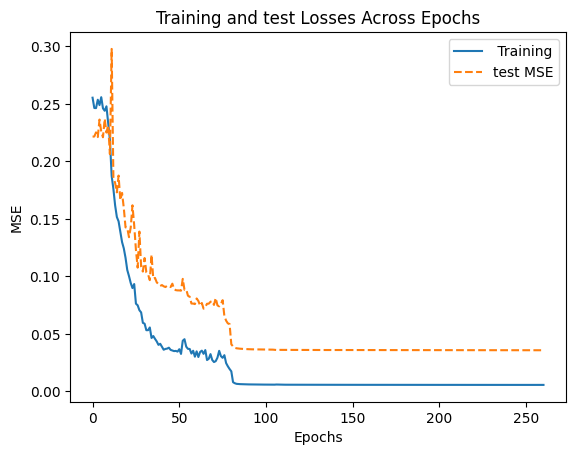

261


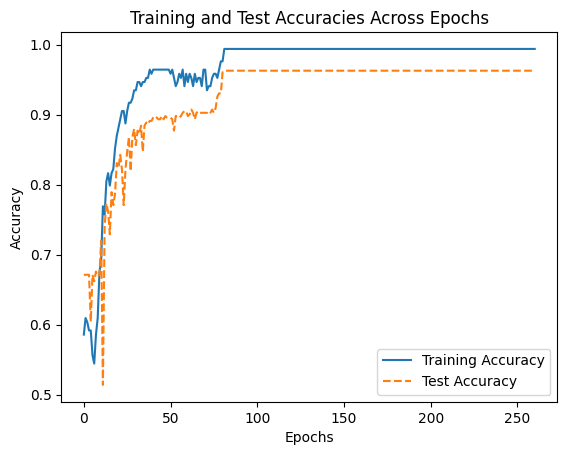

Refit Time: 4.44 seconds
Working with seed: 44
Starting epoch 1
0.2351624428949974
Starting epoch 2
0.21863464617894757
Starting epoch 3
0.2300134111126816
Starting epoch 4
0.22992162540968922
Starting epoch 5
0.220258881924329
Starting epoch 6
0.22256574220955372
Starting epoch 7
0.24091423875479787
Starting epoch 8
0.24326978416906464
Starting epoch 9
0.2370056159518383
Starting epoch 10
0.249361509491724
Starting epoch 11
0.19786244924870078
Starting epoch 12
0.16612034549729693
Starting epoch 13
0.1676990152724708
Starting epoch 14
0.12842405424722797
Starting epoch 15
0.12360575604139336
Starting epoch 16
0.046060612628934905
Starting epoch 17
0.013164742673796826
Starting epoch 18
0.006930892254954584
Starting epoch 19
0.00538615290807448
Starting epoch 20
0.003576250459041653
Starting epoch 21
0.0029214584382889035
Starting epoch 22
0.0025058890624441795
Starting epoch 23
0.0022246929872414547
Starting epoch 24
0.001921227774598972
Starting epoch 25
0.0016938696179648913
Startin

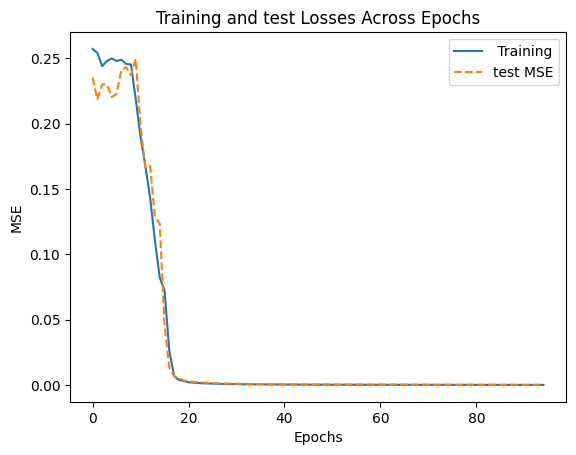

95


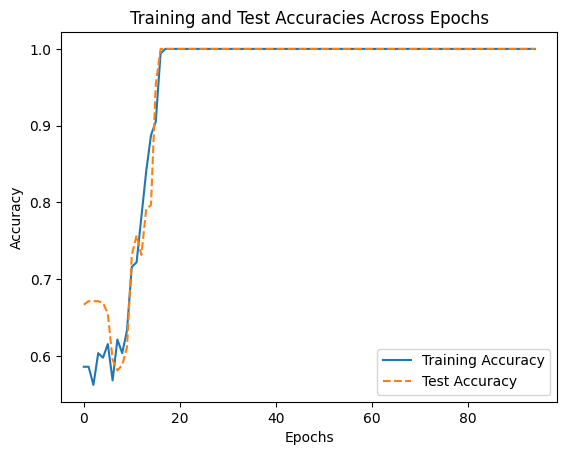

Refit Time: 1.75 seconds
Working with seed: 45
Starting epoch 1
0.23059995413792353
Starting epoch 2
0.2800096561787305
Starting epoch 3
0.22548436470053815
Starting epoch 4
0.2720844491074483
Starting epoch 5
0.16363738788964433
Starting epoch 6
0.14816784095536503
Starting epoch 7
0.09967260285392748
Starting epoch 8
0.04557892486142615
Starting epoch 9
0.014824480376706493
Starting epoch 10
0.007826891881888043
Starting epoch 11
0.005355071921022264
Starting epoch 12
0.004169953138679611
Starting epoch 13
0.0034231347521266864
Starting epoch 14
0.0028684946554238667
Starting epoch 15
0.0024530268217656864
Starting epoch 16
0.002125318305776023
Starting epoch 17
0.0019440253484019733
Starting epoch 18
0.0017475152085858604
Starting epoch 19
0.0015628660570386004
Starting epoch 20
0.0014467944482156006
Starting epoch 21
0.0013565186400902112
Starting epoch 22
0.001210116365891062
Starting epoch 23
0.001121188618492818
Starting epoch 24
0.0010624287464856429
Starting epoch 25
0.0009951

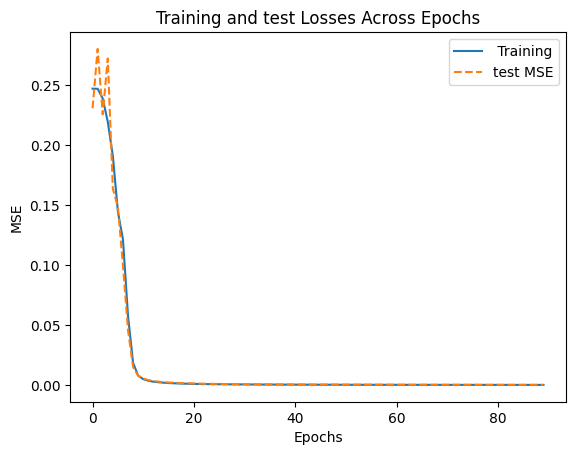

90


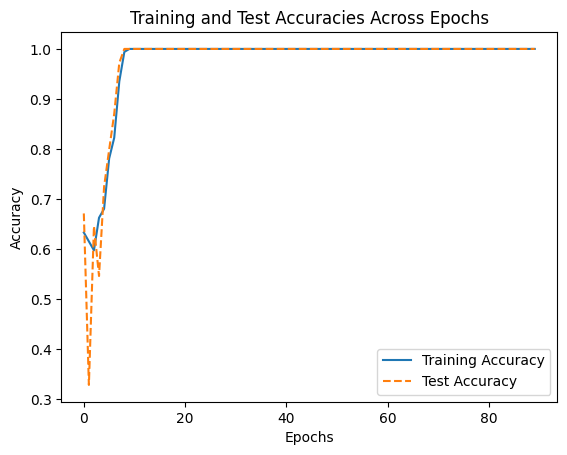

Refit Time: 1.63 seconds
TRAIN MEAN MSE 0.0010182614521557674
TRAIN STD 0.0020271347456927687
TEST MEAN MSE 0.007062081313733257
TEST STD 0.012975994242009627


In [216]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params,seeds=SEEDS)  


accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



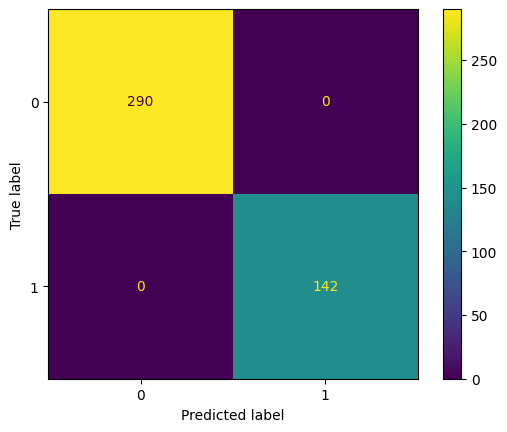

------------------------------------------------------------------------------------------------------


In [217]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 3

Actual iter 0.0%
Working with seed: 42
Early stopping: 189
Early stopping: 138
Early stopping: 205
Early stopping: 131
Early stopping: 189
5


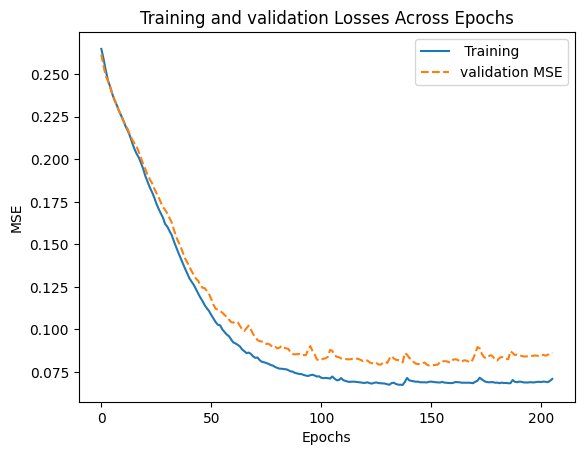

TRAIN MEAN MSE 0.07091041885444911
TRAIN STD 0.0
VALIDATION MEAN MSE 0.08619937151670456
VALIDATION STD 0.0


In [218]:
input_size = 17  
output_size = 1
'''params_grid_u = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0.0001,0.02,0.001,0.1,0.2],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}


params_grid_sp = {
    "hidden_size": [4,5],
    "learning_rate": [0.1, 0.05, 0.2],
    "batch_size": [16,32],
    "weight_decay": [0.01,0.1,0.2],
    "momentum": [0.4, 0.01, 0.05, 0.1],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}
'''
params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.1],
    "batch_size": [32],
    "weight_decay": [0.01],
    "momentum": [0.4],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}

dataset_train_part = read_ds(TR_PATH_3)
dataset_test_part = read_ds(TS_PATH_3)

dataset = dataset_train_part
best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size,seeds = [SEED])


In [219]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.1 
Best batch size: 32 
Best weight decay: 0.01 
Best momentum: 0.4
(0.08619937151670456, 0.07091041885444911, 0.1, 600, MSELoss(), 4, 0.4, <class 'torch.optim.sgd.SGD'>, 0.01, 32)


Working with seed: 40
Starting epoch 1
0.2435179407949801
Starting epoch 2
0.2411840304180428
Starting epoch 3
0.23870404837308107
Starting epoch 4
0.23651903757342585
Starting epoch 5
0.2345319522751702
Starting epoch 6
0.23212354437068658
Starting epoch 7
0.23029275128134974
Starting epoch 8
0.2278571531728462
Starting epoch 9
0.22578102129477043
Starting epoch 10
0.22324071107087312
Starting epoch 11
0.22079027913234853
Starting epoch 12
0.21840473843945396
Starting epoch 13
0.21559239537627609
Starting epoch 14
0.2128861496845881
Starting epoch 15
0.21025348868634966
Starting epoch 16
0.20715999879218913
Starting epoch 17
0.20417770522612114
Starting epoch 18
0.20104782780011496
Starting epoch 19
0.19800376450573956
Starting epoch 20
0.19468708060405873
Starting epoch 21
0.19164937182709021
Starting epoch 22
0.1882460790651816
Starting epoch 23
0.18469437956809998
Starting epoch 24
0.18139399532918576
Starting epoch 25
0.17778371550418712
Starting epoch 26
0.1742161915258125
Starti

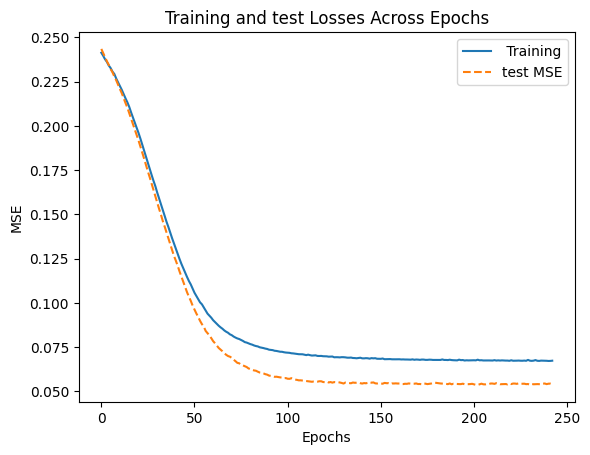

243


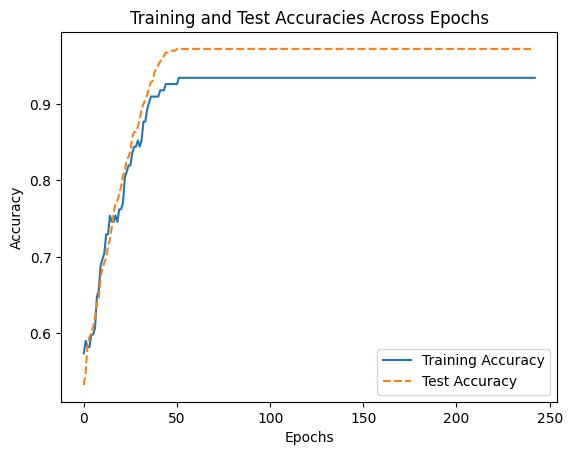

Refit Time: 1.25 seconds
Working with seed: 41
Starting epoch 1
0.300228476524353
Starting epoch 2
0.2912077020715784
Starting epoch 3
0.282681941986084
Starting epoch 4
0.2747067731839639
Starting epoch 5
0.2679558385301519
Starting epoch 6
0.2617107894685533
Starting epoch 7
0.25600664372797366
Starting epoch 8
0.25088427905683164
Starting epoch 9
0.2461635591807189
Starting epoch 10
0.24193249035764625
Starting epoch 11
0.23771595899705533
Starting epoch 12
0.23363672914328398
Starting epoch 13
0.2295557161172231
Starting epoch 14
0.2259397550865456
Starting epoch 15
0.22234730588065255
Starting epoch 16
0.2188596742020713
Starting epoch 17
0.21557974925747625
Starting epoch 18
0.21204149060779148
Starting epoch 19
0.2084495171352669
Starting epoch 20
0.2049258362363886
Starting epoch 21
0.20133710073100197
Starting epoch 22
0.19771518806616464
Starting epoch 23
0.19403022196557787
Starting epoch 24
0.1901040678774869
Starting epoch 25
0.18632870581414965
Starting epoch 26
0.1822784

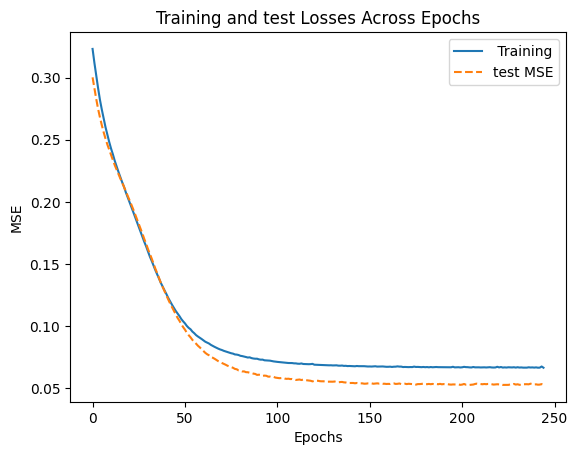

245


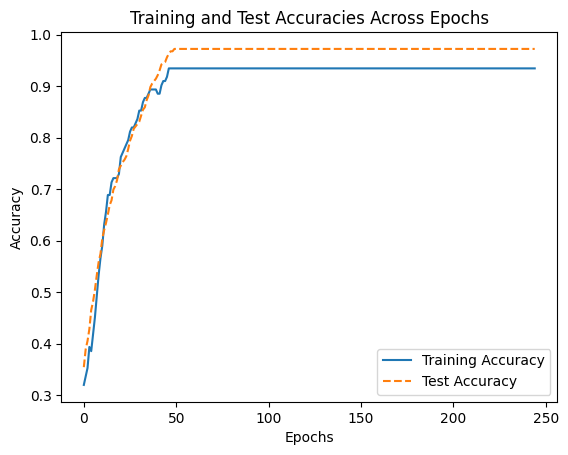

Refit Time: 1.18 seconds
Working with seed: 42
Starting epoch 1
0.2225221892197927
Starting epoch 2
0.21466815250891227
Starting epoch 3
0.20758051673571268
Starting epoch 4
0.20047689256844697
Starting epoch 5
0.19493845270739663
Starting epoch 6
0.1891095251948745
Starting epoch 7
0.18361652338946308
Starting epoch 8
0.17860060985441562
Starting epoch 9
0.17375704370163106
Starting epoch 10
0.1689098819538399
Starting epoch 11
0.16431403436042644
Starting epoch 12
0.15958128262449195
Starting epoch 13
0.15500909310800057
Starting epoch 14
0.15067149257218396
Starting epoch 15
0.14660402083838428
Starting epoch 16
0.14225248164600796
Starting epoch 17
0.13812150226698983
Starting epoch 18
0.13410841370070423
Starting epoch 19
0.12997889711900992
Starting epoch 20
0.12603713627214785
Starting epoch 21
0.12206006712383694
Starting epoch 22
0.11870986885494655
Starting epoch 23
0.11507300591027295
Starting epoch 24
0.1115604782546008
Starting epoch 25
0.10821432785855399
Starting epoch 2

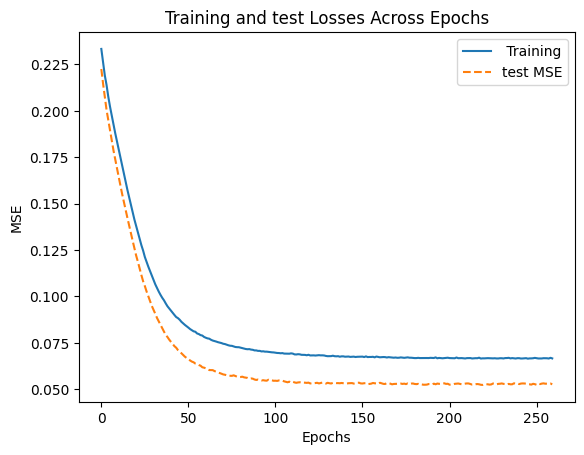

260


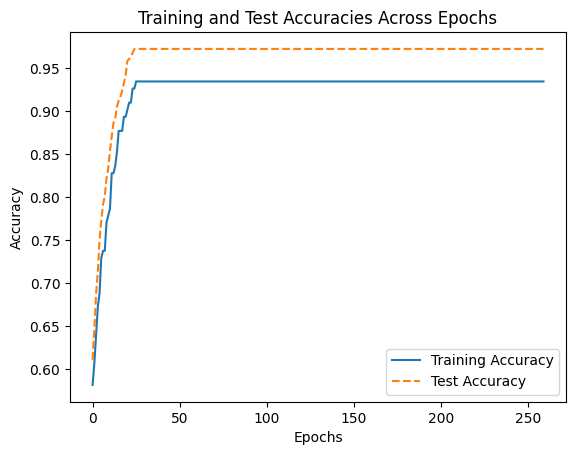

Refit Time: 1.24 seconds
Working with seed: 43
Starting epoch 1
0.28852507251280324
Starting epoch 2
0.2789027514281096
Starting epoch 3
0.2701845621621167
Starting epoch 4
0.2619894058616073
Starting epoch 5
0.2544926896139427
Starting epoch 6
0.247725753320588
Starting epoch 7
0.24196641423084117
Starting epoch 8
0.23598988740532487
Starting epoch 9
0.23053821369453711
Starting epoch 10
0.22539093869703788
Starting epoch 11
0.22029024141806144
Starting epoch 12
0.21548822246215962
Starting epoch 13
0.21019011901484597
Starting epoch 14
0.20562477354650144
Starting epoch 15
0.20078857298250552
Starting epoch 16
0.19595810715798978
Starting epoch 17
0.19142822921276093
Starting epoch 18
0.1864023788107766
Starting epoch 19
0.18194739079033886
Starting epoch 20
0.17719391761002717
Starting epoch 21
0.17254728244410622
Starting epoch 22
0.16825274847171925
Starting epoch 23
0.16368666843131738
Starting epoch 24
0.15926373501618704
Starting epoch 25
0.15495795673794216
Starting epoch 26
0

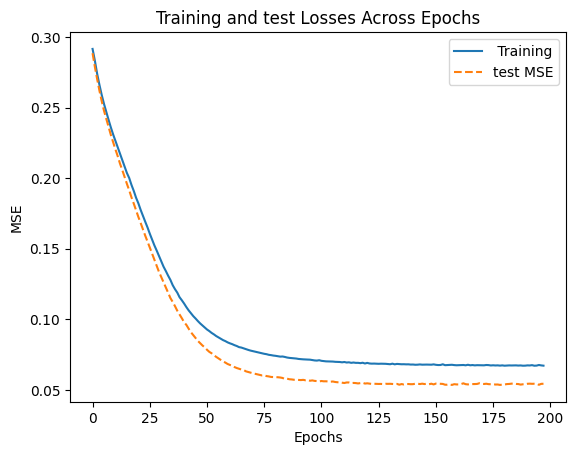

198


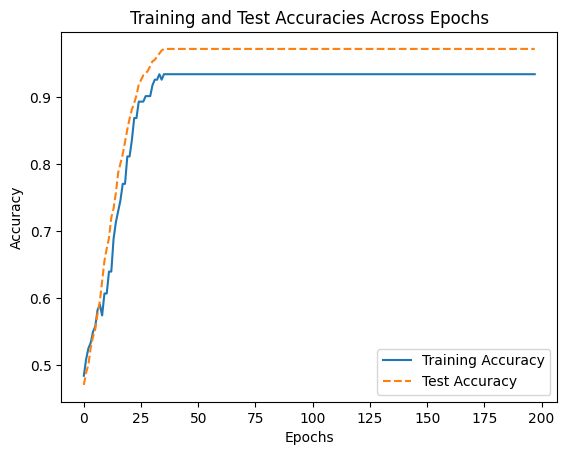

Refit Time: 0.98 seconds
Working with seed: 44
Starting epoch 1
0.2480386683234462
Starting epoch 2
0.24620788075305797
Starting epoch 3
0.244231343821243
Starting epoch 4
0.24249968539785455
Starting epoch 5
0.24064893634231002
Starting epoch 6
0.23897861882492347
Starting epoch 7
0.23726997883231551
Starting epoch 8
0.23554851997781684
Starting epoch 9
0.2338470678638529
Starting epoch 10
0.23217430214087167
Starting epoch 11
0.23020404246118334
Starting epoch 12
0.22821734459311874
Starting epoch 13
0.22605005348170246
Starting epoch 14
0.22397012953405027
Starting epoch 15
0.22172543075349596
Starting epoch 16
0.21922076797043835
Starting epoch 17
0.21653663449817234
Starting epoch 18
0.21386028771047239
Starting epoch 19
0.21091266252376414
Starting epoch 20
0.20808626766558047
Starting epoch 21
0.20497952787964432
Starting epoch 22
0.2018006648178454
Starting epoch 23
0.19830079100750111
Starting epoch 24
0.19491130775875515
Starting epoch 25
0.19145985665144744
Starting epoch 26

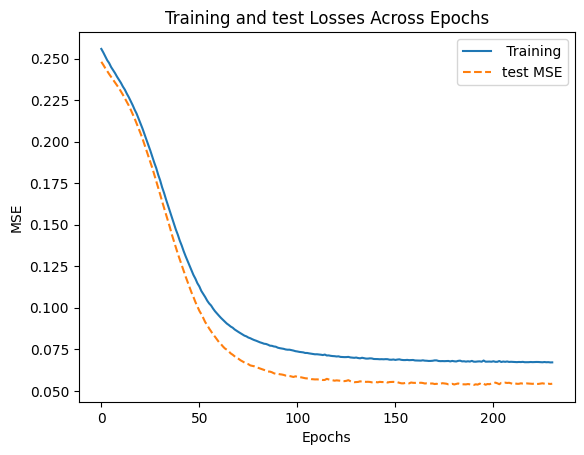

231


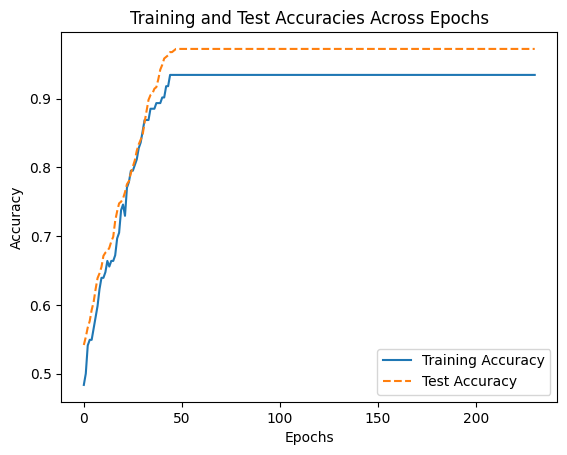

Refit Time: 1.14 seconds
Working with seed: 45
Starting epoch 1
0.23362545945026256
Starting epoch 2
0.2305308006427906
Starting epoch 3
0.22771117311936837
Starting epoch 4
0.2250059015221066
Starting epoch 5
0.22217101907288586
Starting epoch 6
0.21954638759295145
Starting epoch 7
0.21688955580746686
Starting epoch 8
0.21424260349185378
Starting epoch 9
0.2114161159153338
Starting epoch 10
0.20876614804621096
Starting epoch 11
0.2058809808006993
Starting epoch 12
0.20287210356306146
Starting epoch 13
0.19982291150976111
Starting epoch 14
0.19676881752632283
Starting epoch 15
0.1935871254514765
Starting epoch 16
0.1900801470986119
Starting epoch 17
0.18658053433453595
Starting epoch 18
0.18284068725727223
Starting epoch 19
0.17907409535513985
Starting epoch 20
0.17550278592992713
Starting epoch 21
0.17157161235809326
Starting epoch 22
0.16767429808775583
Starting epoch 23
0.16361993716822731
Starting epoch 24
0.15982590588154616
Starting epoch 25
0.15586493412653604
Starting epoch 26


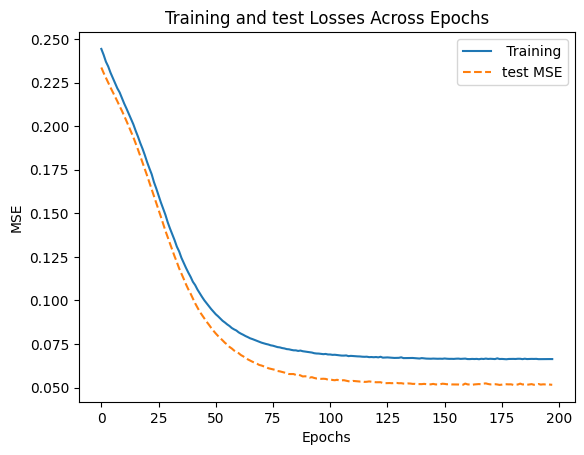

198


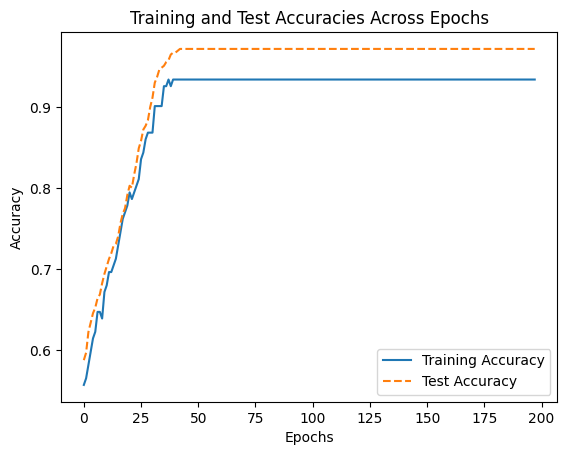

Refit Time: 1.00 seconds
TRAIN MEAN MSE 0.06683762899798448
TRAIN STD 0.00036788161466152336
TEST MEAN MSE 0.05325615563556368
TEST STD 0.0010159211645576205


In [220]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params,seeds=SEEDS)  

accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



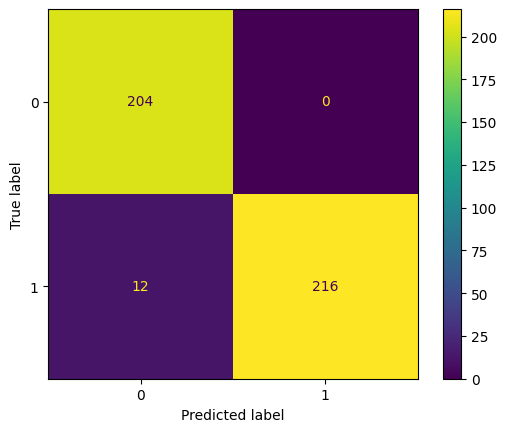

------------------------------------------------------------------------------------------------------


In [221]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")
